## Single and double layer potentials, and masks

In [1]:
using ImmersedLayers

In [2]:
using LinearAlgebra

In [3]:
using Plots

### Set up the grid and some data structures

In [64]:
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)
g = PhysicalGrid(xlim,ylim,Δx)

w = Nodes(Dual,size(g),dtype=Float64);
q = Edges(Primal,w);

od = Nodes(Dual,w)
od .= 1;

oc = Nodes(Primal,w)
oc .= 1;

### Test some grid identities

For $u_1, u_2 \in \mathcal{C}$,
$$G(u_1\circ u_2) = G u_1 \circ I_\mathcal{C}^\mathcal{F} u_2 + I_\mathcal{C}^\mathcal{F} u_1 \circ  G u_2 $$

This is the discrete equivalent of

$$ \nabla (u_1 u_2) = u_2 \nabla u_1 + u_1 \nabla u_2 $$

In [65]:
u1 = Nodes(Primal,w,dtype=Float64)
u2 = Nodes(Primal,w,dtype=Float64)
qtmp = Edges(Primal,u1)

u1 .= randn(size(u1));
u2 .= randn(size(u2));

In [66]:
lhs = grad(u1∘u2);
rhs = grad(u1)∘ grid_interpolate!(qtmp,u2) + grid_interpolate!(qtmp,u1) ∘ grad(u2);
norm(lhs-rhs)

2.3990297010627867e-16

For $u \in \mathcal{C}$, $q \in \mathcal{F}$,

$$ D (I_\mathcal{C}^\mathcal{F}u \circ q) = I_\mathcal{F}^\mathcal{C} (Gu\circ q) + u \circ D q $$

This is the discrete equivalent of

$$ \nabla \cdot (u \mathbf{q}) = \nabla u \cdot \mathbf{q} + u \nabla\cdot\mathbf{q} $$

In [118]:
u = Nodes(Primal,w,dtype=Float64)
q = Edges(Primal,u)
utmp = Nodes(Primal,u)
qtmp = Edges(Primal,u)

u .= randn(size(u));
q .= randn(size(q));

lhs = Nodes(Primal,u)
rhs = Nodes(Primal,u);

In [68]:
lhs .= divergence(grid_interpolate!(qtmp,u)∘q);
grid_interpolate!(utmp,grad(u)∘q)
rhs .= utmp + u ∘ divergence(q);
norm(lhs[2:end-1,2:end-1]-rhs[2:end-1,2:end-1])

1.6555625601490608e-13

Notice that here we have to omit the nodes on the boundary from the comparison, since these are corrupted by spurious values from the ghost cells.

Now evaluate
$$I_F^C L_F = L_C I_F^C$$
by evaluating both sides on some random data $q \in \mathcal{F}$.

In [124]:
q .= 0
q.u[3:end-3,3:end-3] .= rand(size(q.u[3:end-3,3:end-3])...)

lhs .= laplacian(grid_interpolate!(u,q))
rhs .= grid_interpolate!(u,laplacian(q));
#norm(lhs[2:end-1,2:end-1]-rhs[2:end-1,2:end-1])
lhs-rhs

Nodes{Primal,600,600,Float64,Array{Float64,2}} data
Printing in grid orientation (lower left is (1,1))
599×599 Array{Float64,2}:
  0.0          0.0           0.0          …   0.0          0.0  0.0
  0.0          0.0           0.0              0.0          0.0  0.0
  0.0          0.0           0.0              0.0          0.0  0.0
 -0.291713     0.0           0.0             -1.11022e-16  0.0  0.0
 -0.386096     0.0           1.11022e-16     -1.11022e-16  0.0  0.0
 -0.435451    -3.33067e-16   0.0          …   0.0          0.0  0.0
 -0.328314     0.0           0.0              0.0          0.0  0.0
 -0.223963    -1.11022e-16  -1.11022e-16      0.0          0.0  0.0
 -0.268317     0.0          -2.22045e-16      0.0          0.0  0.0
 -0.00516732   0.0           0.0              0.0          0.0  0.0
 -0.0847054    0.0          -1.11022e-16  …   0.0          0.0  0.0
 -0.0834516   -1.11022e-16  -2.22045e-16      0.0          0.0  0.0
 -0.438806    -2.22045e-16   0.0              1.11022e-

and similarly,
$$I_C^F L_C = L_F I_C^F$$

In [70]:
u .= randn(size(u));
q .= 0
lhs = Edges(Primal,u)
rhs = Edges(Primal,u)
lhs .= laplacian(grid_interpolate!(q,u))
q .= 0
rhs .= grid_interpolate!(q,laplacian(u));
norm(lhs.v[3:end-2,3:end-2]-rhs.v[3:end-2,3:end-2])

1.8855074449445699e-13

Here, we have to avoid points that are in the first two rows/columns of the grid.

### Set up a shape

In [71]:
radius = 1.0
body = Circle(radius,1.5*Δx)
X = VectorData(collect(body))
f = VectorData(X,dtype=Float64)
ϕ = ScalarData(f)
regop = Regularize(X,Δx,I0=origin(g),weights=dlengthmid(body),ddftype=CartesianGrids.Yang3)

ds = areas(body)
nrm = normals(body);

os = ones(ϕ)
ov1 = ones(f,1)
ov2 = ones(f,2);

The following approximate

$$\int_S \mathbf{n}\,\mathrm{d}S = 0$$

In [72]:
dot(ov1,ds,nrm)

4.822531263215524e-16

In [73]:
dot(ov2,ds,nrm)

9.43689570931383e-16

### Pointwise data

In [74]:
ϕ1 = ScalarData(f)
ϕ2 = ScalarData(f);
ϕ1 .= 1
ϕ2 .= 1;

$$<1,1>_{S} \,\approx \int_S\mathrm{d}S$$

In [75]:
dot(ϕ1,ds,ϕ2)

6.282238904073622

### Apply the regularization operator to some data

In [76]:
u = Nodes(Primal,w);
q = Edges(Primal,w);

In [77]:
Rc = RegularizationMatrix(regop,ϕ,oc);
Ec = InterpolationMatrix(regop,oc,ϕ);

Let us first show that `Rc` and `Ec` are transposes of one another with respect to the inner product spaces:

In [78]:
u .= randn(size(u))
ϕ .= randn(size(ϕ))
dot(Rc*ϕ,u,g) - dot(ϕ,ds,Ec*u)

-2.7755575615628914e-17

Let us compute an approximation of the integral

$$\int_{R^2} \delta(\chi(\mathbf{x}))\,\mathrm{d}\mathbf{x} = \int_{\chi=0}\,\mathrm{d}S$$

In [79]:
Rf = RegularizationMatrix(regop,f,q);
Ef = InterpolationMatrix(regop,q,f);

In [80]:
f .= 1;

In [81]:
q .= 1;
dot(q.u,(Rf*f).u,g)-sum(ds)

4.440892098500626e-15

Note that the inner product on the surface points is just the sum of the surface areas:

In [82]:
dot(f.u,ds,f.u)-sum(ds)

0.0

Since this is a circle of radius 1, we know the exact perimeter and can compare our approximation:

In [83]:
dot(q.u,(Rf*f).u,g)-2π

-0.0009464031059600586

$$ <1,I_\mathcal{F}^\mathcal{C}(Gf \circ R_\mathcal{F}\mathbf{n})>_\mathcal{C} = < I_F G f, \mathbf{n}>_{\mathcal{V}^N}$$

In [84]:
utmp = similar(u)
grid_interpolate!(utmp,grad(u)∘(Rf*nrm))
dot(oc,utmp,g) - dot(nrm,ds,Ef*grad(u))

5.551115123125783e-17

### Identities for grid interpolation operators

In [25]:
u1 .= 0
u2 .= 0
q .= 0
u1[3:end-2,3:end-2] .= randn(size(u1[3:end-2,3:end-2]))
u2[3:end-2,3:end-2] .= randn(size(u2[3:end-2,3:end-2]))
q.u[3:end-2,3:end-2] .= randn(size(q.u[3:end-2,3:end-2]))
q.v[3:end-2,3:end-2] .= randn(size(q.v[3:end-2,3:end-2]))
u1vec = similar(q)
u2vec = similar(q)
qcell = similar(u)
grid_interpolate!(u1vec,u1)
grid_interpolate!(u2vec,u2)
grid_interpolate!(qcell,q)
dot(u1vec∘grad(u2),q∘u2vec,g) - dot(u1vec∘u2vec,q∘grad(u2),g)

0.0

In [26]:
inner = Mask(body,g,u1)
outer = ComplementaryMask(inner)

ComplementaryMask{209,600,600,Primal}(Mask{209,600,600,Primal}(Primal nodes in a (nx = 600, ny = 600) cell grid of type Float64 data
  Number of Primal nodes: (nx = 599, ny = 599)))

In [27]:
u1 .= 0
u2 .= 0
q .= 0
u1[3:end-2,3:end-2] .= randn(size(u1[3:end-2,3:end-2]))
u2[3:end-2,3:end-2] .= randn(size(u2[3:end-2,3:end-2]))
q.u[3:end-2,3:end-2] .= randn(size(q.u[3:end-2,3:end-2]))
q.v[3:end-2,3:end-2] .= randn(size(q.v[3:end-2,3:end-2]))
dot(inner(u1)+outer(u2),divergence(q),g) + dot(grad(inner(u1)+outer(u2)),q,g)

1.547373340571312e-15

### Compute divergence of a surface tensor

In [28]:
Σ = TensorData(f);
vb = VectorData(f);
dq = EdgeGradient(Primal,q);

In [29]:
Rt = RegularizationMatrix(regop,Σ,dq);
#Et = InterpolationMatrix(regop,dq,Σ);

In [30]:
vb.u .= 1;
vb.v .= 0;

In [31]:
Σ .= vb*nrm .+ nrm*vb;

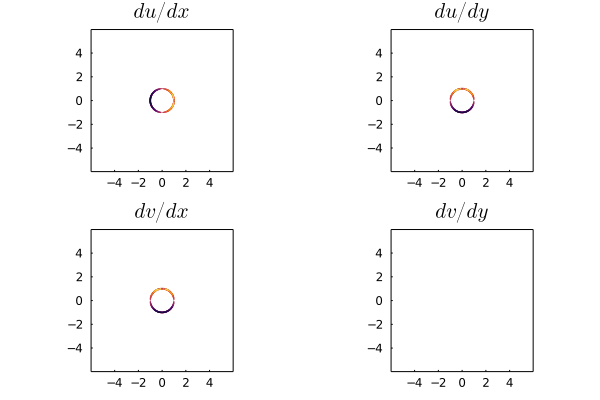

In [32]:
plot(Rt*Σ,g)

In [33]:
divergence!(q,Rt*Σ);

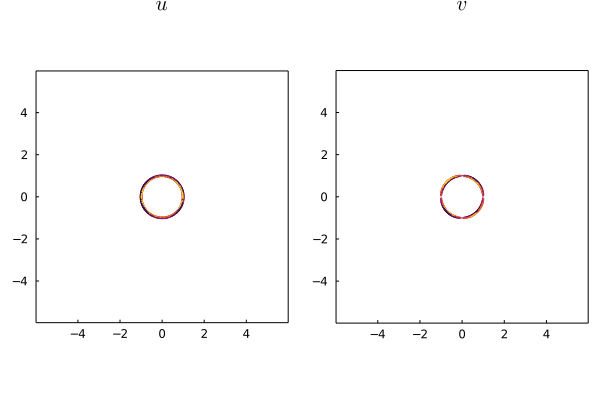

In [34]:
plot(q,g)

In [35]:
xu, yu = coordinates(q.u,g)
xv, yv = coordinates(q.v,g)

(-5.98:0.02:5.98, -5.99:0.02:5.99)

In [36]:
xv[300]

0.0

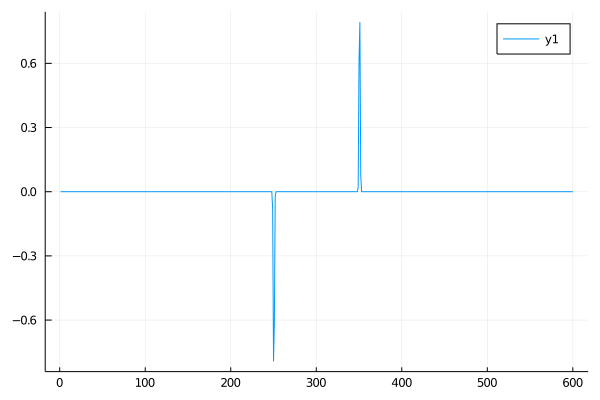

In [37]:
plot(q.v[300,:])

In [38]:
w = curl(divergence!(q,Rt*Σ));

In [39]:
xn, yn = coordinates(w,g);

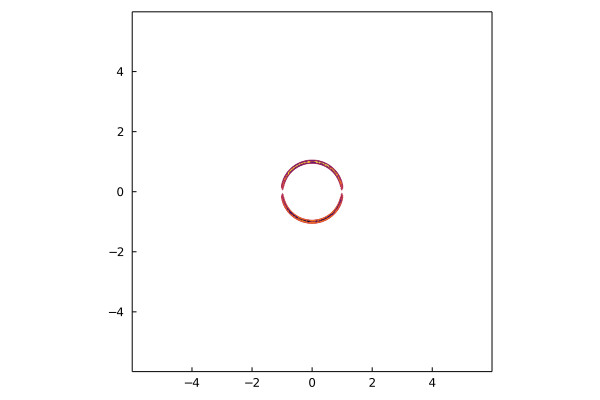

In [40]:
plot(w,g)

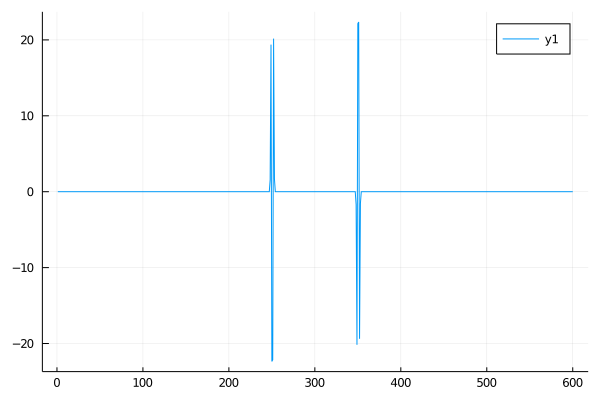

In [41]:
plot(w[300,:])

### Try some double and single layers

In [89]:
dlayer = DoubleLayer(body,g,u)
slayer = SingleLayer(body,g,u)

Single-layer potential mapping
  from 209 scalar-valued point data of Float64 type
  to a 600 x 600 grid of Primal nodal data


In [91]:
dot(oc,dlayer(1),g)

5.638867150992156e-15

In [108]:
qx = similar(q)
xc, yc = coordinates(q.u,g)
qx.u .= xc;
dot(qx,Rf*nrm,g)

3.141119452036813

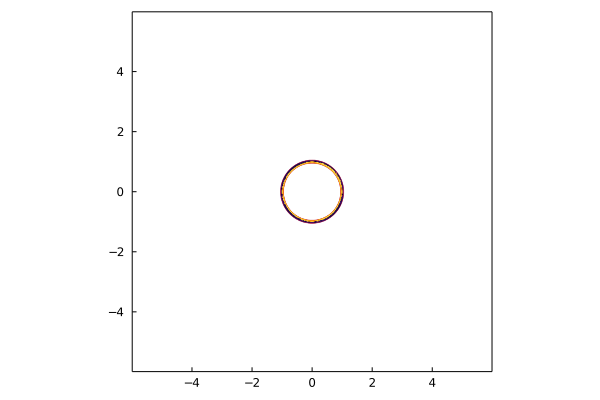

In [44]:
xg, yg = coordinates(w,g)
plot(xg,yg,real(dlayer(1)))

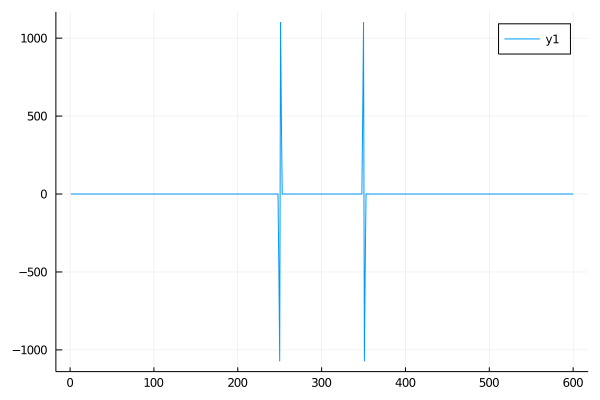

In [45]:
plot(real(dlayer(1))[301,:])

In [46]:
dot(od,slayer(1),g)-2π*radius

-0.0009464031059600586

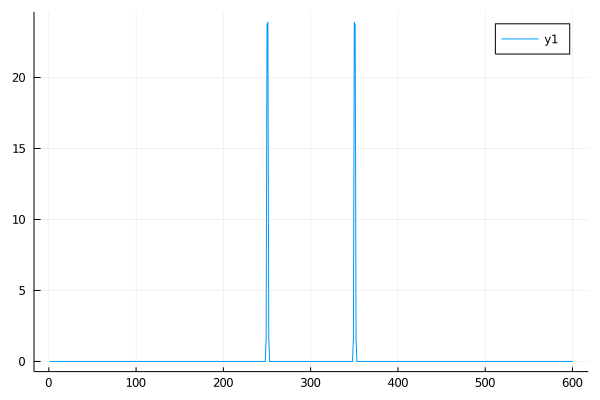

In [47]:
plot(real(slayer(1))[301,:])

### Try some masks

In [48]:
xlim = (-1,1)
ylim = (-1,1)
Δx = 0.005
g = PhysicalGrid(xlim,ylim,Δx)
w = Nodes(Dual,size(g));

In [49]:
a = 0.5
b = 0.25
k = 1.5
body = Rectangle(a,b,k*Δx)

body2 = Circle(0.25,k*Δx)
T2! = RigidTransform((0.2,0.6),0.0)
T2!(body2)

body3 = NACA4(0.0,0.0,0.12,k*Δx)
T3! = RigidTransform((-0.25,-0.6),-10*π/180)
T3!(body3)

NACA 4-digit airfoil with 271 points and length 1.0 and thickness 0.12
   Current position: (-0.25,-0.6)
   Current angle (rad): -0.17453292519943295


In [50]:
bl = BodyList()
push!(bl,body)
push!(bl,body2)
push!(bl,body3)

3-element Array{Body,1}:
 Rectangular body with 396 points and half-lengths (0.5,0.25)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0

 Circular body with 209 points and radius 0.25
   Current position: (0.2,0.6)
   Current angle (rad): 0.0

 NACA 4-digit airfoil with 271 points and length 1.0 and thickness 0.12
   Current position: (-0.25,-0.6)
   Current angle (rad): -0.17453292519943295


In [51]:
inner = Mask(bl,g,w)
outer = ComplementaryMask(inner)

ComplementaryMask{876,416,416,Dual}(Mask{876,416,416,Dual}(Dual nodes in a (nx = 416, ny = 416) cell grid of type Float64 data
  Number of Dual nodes: (nx = 416, ny = 416)))

In [52]:
w .= 1;

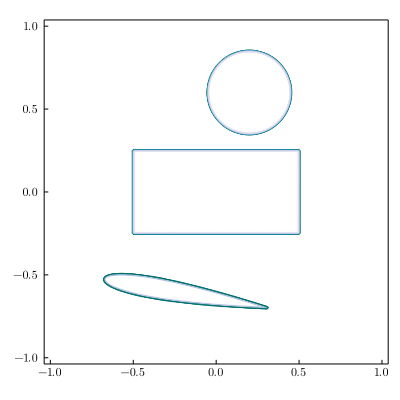

In [53]:
plot(inner(w),g,color=cgrad(:PuBuGn_7,rev=true),formatter=:latex,size=(400,400))
#savefig("MaskedShapes2D.pdf")

In [54]:
xg, yg = coordinates(w,g);

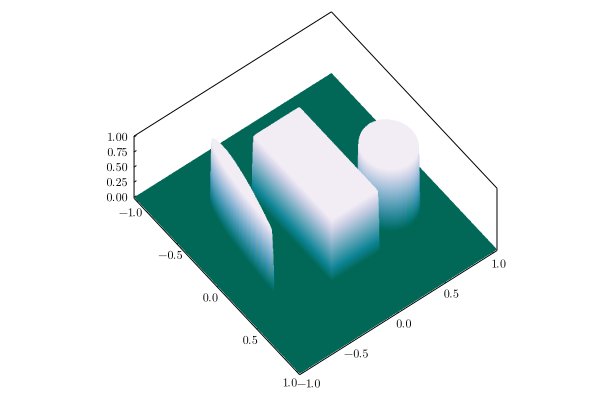

In [55]:
psurf = surface(xg,yg,inner(w),camera=(50,80),color=cgrad(:PuBuGn_7,rev=true),formatter=:latex)
#savefig(psurf,"MaskedShapes.pdf")
display(psurf)

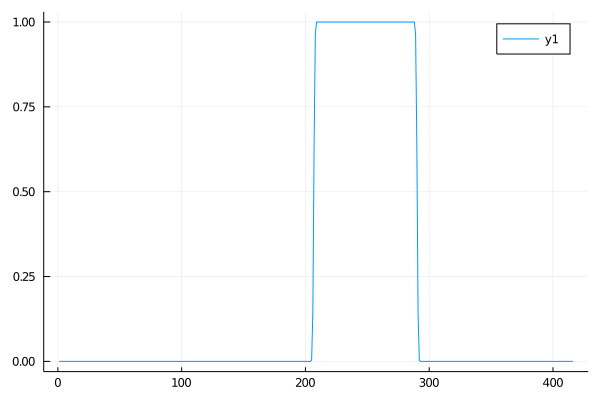

In [56]:
plot(real(inner(w))[:,301])

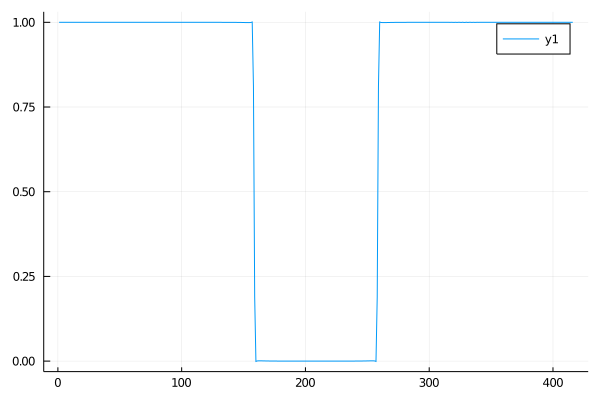

In [57]:
plot(real(outer(w))[301,:])

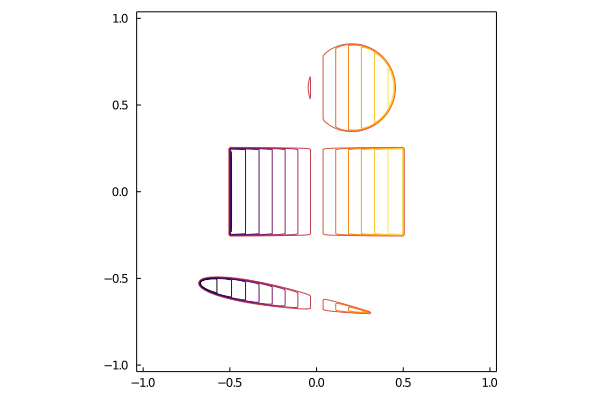

In [59]:
w .= sin.(xg)
#plot(xg,yg,real(w))
plot(xg,yg,real(inner(w)))